# 동작유사도 - NexTep

## Mediapipe로 관절 특징점 검출

In [ ]:
!pip install mediapipe

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 32.9 MB 1.4 MB/s 


In [ ]:
import cv2
import mediapipe as mp
import numpy as np
from tqdm import tqdm

mp_drawing = mp.solutions.drawing_utils
mp_pose = mp.solutions.pose
mp_drawing_styles = mp.solutions.drawing_styles

- 기준 포즈

In [ ]:
# 영상 불러오기
cap = cv2.VideoCapture('./BTS Dynamite_target.mp4')
lm1 = []
count = 0

## 미디어 파이프 instance 결정
with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
    
    while cap.isOpened():
        ret, frame = cap.read()
        
        if not ret:
            print("[프레임 수신 불가] - 종료합니다")
            break
        
        # 이미지를 다시 RGB형식으로 칠함 (먼저는 프레임을 잡아줘야한다)
        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        image.flags.writeable = False # 이미지 다시쓰기
      
        # 탐지하기
        results = pose.process(image)
    
        # 이미지를 RGB로 나타냄
        image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        
        # Extract landmarks
        try:
            landmarks = results.pose_world_landmarks.landmark
            del landmarks[1:11]
            
            ll = []
            for i in landmarks:
                ll.append([i.x, i.y, i.z])
            
            lm1.append(ll)

        except:
            pass
        
        # Render detections
        mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS,
                                mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=2), 
                                mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2) 
                                 )
        # cv2.imwrite("./BTS1/%d.jpg" % count, image)
        # count+=1
        
        # cv2.imshow('Mediapipe Feed', image)

        if cv2.waitKey(10) & 0xFF == 27:
            break

    cap.release()
    cv2.destroyAllWindows()

[프레임 수신 불가] - 종료합니다


- 사용자 포즈1: 같은 동작

In [ ]:
# 영상 불러오기
cap = cv2.VideoCapture('./BTS Dynamite_user.mp4')
lm2 = []
count=0

## 미디어 파이프 instance 결정
with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
    while cap.isOpened():
        ret, frame = cap.read()
        
        if not ret:
            print("[프레임 수신 불가] - 종료합니다")
            break
        
        # 이미지를 다시 RGB형식으로 칠함 (먼저는 프레임을 잡아줘야한다)
        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        image.flags.writeable = False # 이미지 다시쓰기
      
        # 탐지하기
        results = pose.process(image)
    
        # 이미지를 RGB로 나타냄
        image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        
        # Extract landmarks
        try:
            landmarks = results.pose_world_landmarks.landmark
            del landmarks[1:11]
            
            ll = []
            for i in landmarks:
                ll.append([i.x, i.y, i.z])
            
            lm2.append(ll)

        except:
            pass
        
        # Render detections
        mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS,
                                mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=2), 
                                mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2) 
                                 )
        # cv2.imwrite("./BTS2/%d.jpg" % count, image)
        # count+=1
        
        cv2.imshow('Mediapipe Feed', image)

        if cv2.waitKey(10) & 0xFF == 27:
            break

    cap.release()
    cv2.destroyAllWindows()

[프레임 수신 불가] - 종료합니다


In [ ]:
X_train = np.array(lm)
X_test1 = np.array(lm1)
X_test2 = np.array(lm2)
# X_test3 = np.array(lm3)

print(X_train.shape, X_test1.shape, X_test2.shape) #, X_test3.shape)

(11688, 23, 3) (5047, 23, 3) (2526, 23, 3) (2192, 23, 3)


## Pose Estimator

In [ ]:
X_test1 = np.array(lm1)         # 기준 영상
X_test2 = np.array(lm2)         # 사용자 영상

print(X_test1.shape, X_test2.shape)

(5047, 23, 3) (2526, 23, 3)


## Feature Extractor

- 정규화

In [ ]:
X_test1_norm = []

for i in X_test1:
    x = i.T[0]
    y = i.T[1]
    z = i.T[2]
    x_norm = (x - min(x)) / (max(x) - min(x))
    y_norm = (y - min(y)) / (max(y) - min(y))
    z_norm = (z - min(z)) / (max(z) - min(z))
    
    X_test1_norm.append((x_norm.tolist(), y_norm.tolist(), z_norm.tolist()))

In [ ]:
X_test2_norm = []

for i in X_test2:
    x = i.T[0]
    y = i.T[1]
    z = i.T[2]
    x_norm = (x - min(x)) / (max(x) - min(x))
    y_norm = (y - min(y)) / (max(y) - min(y))
    z_norm = (z - min(z)) / (max(z) - min(z))
    
    X_test2_norm.append((x_norm.tolist(), y_norm.tolist(), z_norm.tolist()))

### Link Vector

In [ ]:
link_keypoint = [(0, 1),
(1, 3),
(3,	5),
(5,	7),
(5,	9),
(5,	11),
(1, 13),
(13, 15),
(15, 17),
(17, 19),
(17, 21),
(0, 2),
(2, 4),
(4, 6),
(4, 8),
(4, 10),
(4, 12),
(2, 14),
(14, 16),
(16, 18),
(18, 20),
(18, 22)]

In [ ]:
link_vector1 = []

for land in X_test1_norm:
    a = []
    for link in link_keypoint:
        x = land[0][link[0]] - land[0][link[1]]
        y = land[1][link[0]] - land[1][link[1]]
        z = land[2][link[0]] - land[2][link[1]]
        a.append((x, y, z))
        
    link_vector1.append(a)
    
link_vector2 = []

for land in X_test2_norm:
    a = []
    for link in link_keypoint:
        x = land[0][link[0]] - land[0][link[1]]
        y = land[1][link[0]] - land[1][link[1]]
        z = land[2][link[0]] - land[2][link[1]]
        a.append((x, y, z))
        
    link_vector2.append(a)

### Angle Vector

In [ ]:
angle_keypoint=[
    (0, 1, 3),
    (1, 3, 5),
    (3, 5, 9),
    (1, 13, 15),
    (13, 15, 17),
    (15, 17, 19),
    (15, 17, 21),
    (0, 2, 4),
    (2, 4, 6),
    (4, 6, 10),
    (2, 14, 16),
    (14, 16, 18),
    (16, 18, 20),
    (16, 18, 22)]

In [ ]:
import math

angle_vector1 = []

for land in X_test1_norm:
    a = []
    for angle in angle_keypoint:
        x = np.array([land[0][angle[0]] - land[0][angle[1]], land[1][angle[0]] - land[1][angle[1]], land[2][angle[0]] - land[2][angle[1]]])
        y = np.array([land[0][angle[1]] - land[0][angle[2]], land[1][angle[1]] - land[1][angle[2]], land[2][angle[1]] - land[2][angle[2]]])
        
        분자 = np.dot(x, y)
        분모 = np.sqrt(x.dot(x)) * np.sqrt(x.dot(x))
        try:
            a.append(math.acos(분자 / 분모))
        except:
            a.append(0)
    angle_vector1.append(a)
    
    
angle_vector2 = []

for land in X_test2_norm:
    a = []
    for angle in angle_keypoint:
        x = np.array([land[0][angle[0]] - land[0][angle[1]], land[1][angle[0]] - land[1][angle[1]], land[2][angle[0]] - land[2][angle[1]]])
        y = np.array([land[0][angle[1]] - land[0][angle[2]], land[1][angle[1]] - land[1][angle[2]], land[2][angle[1]] - land[2][angle[2]]])
        
        분자 = np.dot(x, y)
        분모 = np.sqrt(x.dot(x)) * np.sqrt(x.dot(x))
        try:
            a.append(math.acos(분자 / 분모))
        except:
            a.append(0)
    angle_vector2.append(a)

In [ ]:
def data(i, j):
    x = np.array(link_vector1)[i] - np.array(link_vector2)[j]
    y = np.array(angle_vector1)[i] - np.array(angle_vector2)[j]

    산술평균_링크 = [np.mean(x.T[0]), np.mean(x.T[1]), np.mean(x.T[2])]
    표준편차_링크 = [np.std(x.T[0]), np.std(x.T[1]), np.std(x.T[2])]
    제곱평균_링크 = [np.mean(x.T[0]**2), np.mean(x.T[1]**2), np.mean(x.T[2]**2)]
    
    산술평균_앵글 = np.mean(y)
    표준편차_앵글 = np.std(y)
    제곱평균_앵글 = np.mean(y)
    
    return(산술평균_링크+표준편차_링크+제곱평균_링크+[산술평균_앵글]+[표준편차_앵글]+[제곱평균_앵글])

## Pose Similatiry Predictor

In [ ]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [ ]:
k = np.percentile(dis, 25, interpolation='nearest')
num = np.where(dis <= k)[0].tolist()

data_same = []

for n in num:
    data_same.append(data(path[n][0], path[n][1]))

df1 = pd.DataFrame(data_same)
df1[12] = 1

In [ ]:
k = np.percentile(dis, 75, interpolation='nearest')
num = np.where(dis >= k)[0].tolist()

data_dif = []

for n in num:
    data_dif.append(data(path[n][0], path[n][1]))
    
df2 = pd.DataFrame(data_dif)
df2[12] = 0

In [ ]:
df = pd.concat([df1, df2])

### 데이터셋 분리

In [ ]:
from sklearn.model_selection import train_test_split

# train, test 데이터셋 분리
X = df[df.columns[:-1]]
y = df[12]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 123)

### 모델 생성

In [ ]:
from sklearn.metrics import accuracy_score

- SVC

In [ ]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

# # 정규화 작업
# scaler = StandardScaler()
# scaler.fit(X_train)
# X_train = scaler.transform(X_train)

# SVM 모델 생성
sv_clf = SVC(kernel='poly', C = 3, degree = 3, probability=True)
sv_clf.fit(X_train, y_train)

# # test 데이터셋도 정규화(train 데이터셋 기준으로 학습시킨 정규화 모듈 사용)
# X_test = scaler.transform(X_test)

svm_pred = sv_clf.predict(X_test) # 예측 라벨
accuracy_score(y_test, svm_pred)

0.815

- RandomForest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics    
 
# 학습 진행
forest = RandomForestClassifier(n_estimators=100)
forest.fit(X_train, y_train)

# 예측
rf_pred = forest.predict(X_test)

# 정확도 확인
print('정확도 :', metrics.accuracy_score(y_test, rf_pred))

정확도 : 0.9216666666666666


In [ ]:
from sklearn.linear_model import LogisticRegression

logit_clf = LogisticRegression()
logit_clf.fit(X_train, y_train)

lr_pred = logit_clf.predict(X_test)
accuracy_score(y_test, lr_pred)

0.7166666666666667

### 적용

(1988, 1004)


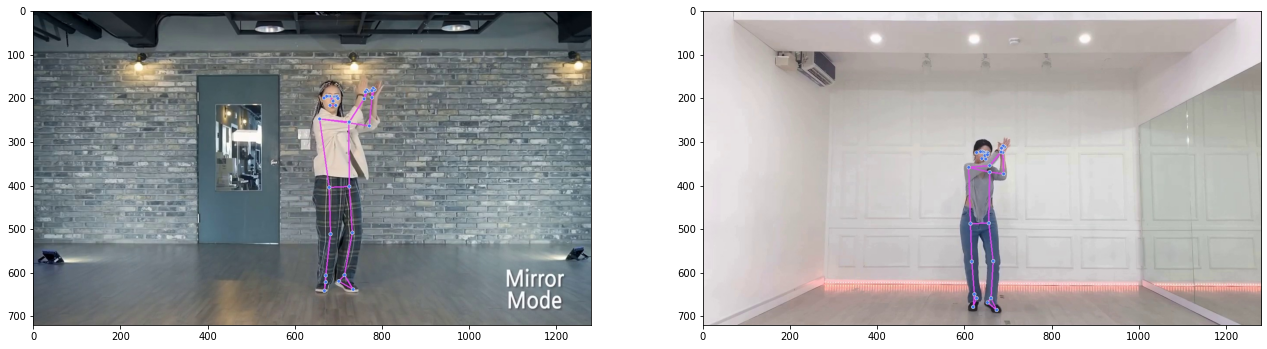

In [ ]:
num = np.where(dis <= 0.1)[0][60]
print(path[num])
image1 = cv2.imread(f'./BTS target/{path[num][0]}.jpg')
image2 = cv2.imread(f'./BTS user/{path[num][1]}.jpg')
plt.figure(figsize=[22,22])
plt.subplot(121); plt.imshow(image1[:,:,::-1])
plt.subplot(122); plt.imshow(image2[:,:,::-1])

(132, 77)


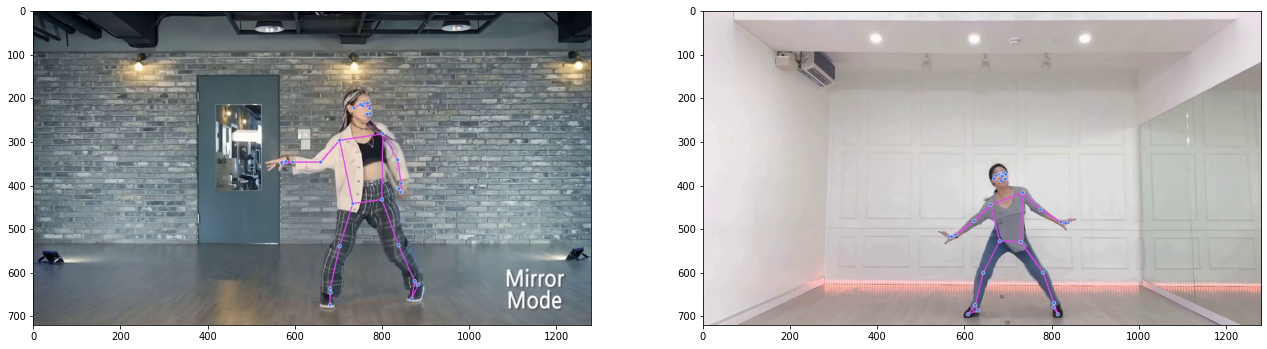

In [ ]:
num = np.where(dis >= 0.1)[0][150]
print(path[num])
image1 = cv2.imread(f'./BTS target/{path[num][0]}.jpg')
image2 = cv2.imread(f'./BTS user/{path[num][1]}.jpg')
plt.figure(figsize=[22,22])
plt.subplot(121); plt.imshow(image1[:,:,::-1])
plt.subplot(122); plt.imshow(image2[:,:,::-1])

In [ ]:
aa = data(1988, 1004)
aa = np.array(aa).reshape(1, -1)

print(sv_clf.predict_proba(aa)[0][1])
print(forest.predict_proba(aa)[0][1])
print(logit_clf.predict_proba(aa)[0][1])

0.8232323625659097
1.0
0.721694268775072


In [ ]:
aa = data(132, 77)
aa = np.array(aa).reshape(1, -1)

print(sv_clf.predict_proba(aa)[0][1])
print(forest.predict_proba(aa)[0][1])
print(logit_clf.predict_proba(aa)[0][1])

0.5310030329669869
0.47
0.6640866817915092


In [ ]:
aa = data(106, 67)
aa = np.array(aa).reshape(1, -1)

print(sv_clf.predict_proba(aa)[0][1])
print(forest.predict_proba(aa)[0][1])
print(logit_clf.predict_proba(aa)[0][1])

0.6310373239719059
0.16
0.5351716794873383


In [ ]:
aa = data(106, 123)
aa = np.array(aa).reshape(1, -1)

print(sv_clf.predict_proba(aa)[0][1])
print(forest.predict_proba(aa)[0][1])
print(logit_clf.predict_proba(aa)[0][1])

0.12521700696096716
0.19
0.2940418139883443
